## 1. Import libraries & setup
We import Spark for data ingestion and cleaning, plus standard Python libraries for data handling, visualization, and deep learning.


In [57]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# NLP
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
stop_words = set(stopwords.words("english"))
import string

# ML preprocessing & evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, optimizers



# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load dataset with Spark
The POE requires Spark for analysis. 
- Dataset source: https://www.kaggle.com/competitions/spooky-author-identification/data?select=train.zip
- We will drop missing rows and do a basic check of record counts per author.


In [58]:
DATA_PATH = "SpookyAuthor.csv" 

spark = SparkSession.builder.master("local[*]").appName("AuthorRNN").getOrCreate()
pdf_spark = spark.read.option("header", True).csv(DATA_PATH)

# Drop missing values
pdf_spark = pdf_spark.dropna(subset=['author', 'text'])

# Quick counts
total_records = pdf_spark.count()
print("Total records:", total_records)
pdf_spark.groupBy("author").count().orderBy(col("count").desc()).show(5)


Total records: 19579
+----------+-----+
|    author|count|
+----------+-----+
|       EAP| 7044|
|       MWS| 5552|
|       HPL| 5451|
|"" he said|   29|
| "" I said|   18|
+----------+-----+
only showing top 5 rows


## 3. Convert to Pandas & clean text
We filter out authors with very few samples (to reduce imbalance) and clean the text by:
- Lowercasing
- Removing URLs
- Removing extra whitespace


In [59]:
MIN_SAMPLES = 100
author_counts = pdf_spark.groupBy("author").count().filter(col("count") >= MIN_SAMPLES)
valid_authors = [row['author'] for row in author_counts.collect()]
pdf_filtered = pdf_spark.filter(col("author").isin(valid_authors))

pdf = pdf_filtered.select("author", "text").toPandas()

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

pdf['text'] = pdf['text'].apply(clean_text)


## 4. Exploratory Data Analysis (EDA)
In this section, we:
- Compute the number of tokens and sentences for each text sample.
- Visualize the distribution of token counts.
- Identify the top authors by number of samples.
- Analyze the most common words (after removing stopwords).
- Generate word clouds for all authors combined and for each individual author.
- Analyse stylistic feature


In [60]:
# Token/sentence counts
pdf['num_tokens'] = pdf['text'].apply(lambda x: len([w for w in word_tokenize(x) if w.isalpha()]))
pdf['num_sentences'] = pdf['text'].apply(lambda x: len(sent_tokenize(x)))

print(pdf[['num_tokens','num_sentences']].describe())

         num_tokens  num_sentences
count  18047.000000   18047.000000
mean      26.010861       1.019615
std       17.198736       0.200997
min        0.000000       1.000000
25%       15.000000       1.000000
50%       23.000000       1.000000
75%       33.000000       1.000000
max      594.000000       6.000000


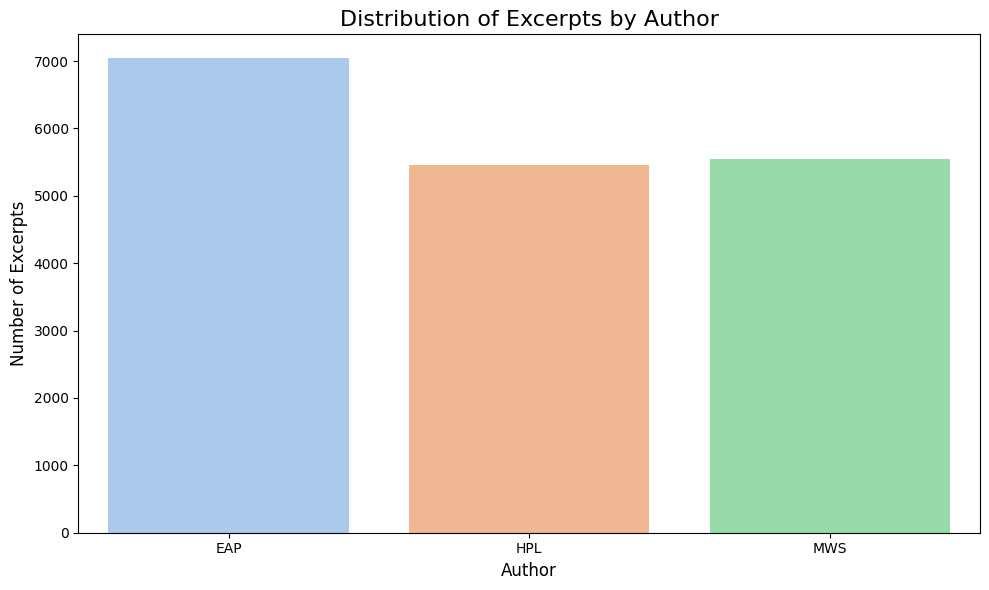

In [61]:
plt.figure(figsize=(10, 6))
sns.countplot(x='author', data=pdf,hue='author', palette='pastel', dodge=False)
plt.title("Distribution of Excerpts by Author", fontsize=16)
plt.xlabel("Author", fontsize=12)
plt.ylabel("Number of Excerpts", fontsize=12)
plt.tight_layout()
plt.savefig("Figure_1.png", dpi=300, bbox_inches='tight')
plt.show()


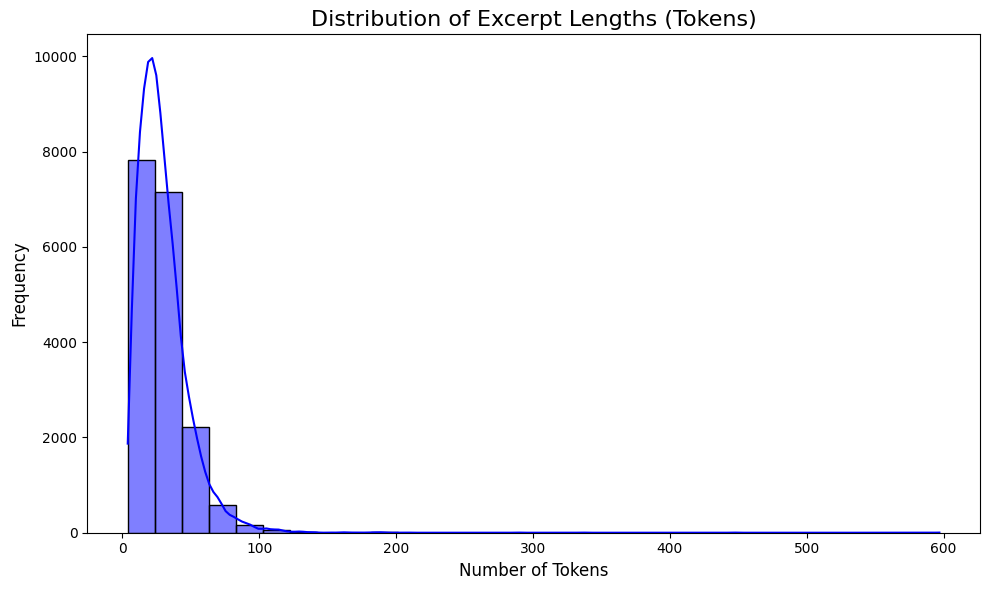

In [62]:
pdf['num_tokens'] = pdf['text'].apply(lambda x: len(word_tokenize(str(x))))

plt.figure(figsize=(10, 6))
sns.histplot(pdf['num_tokens'], bins=30, kde=True, color='blue')
plt.title("Distribution of Excerpt Lengths (Tokens)", fontsize=16)
plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.savefig("Figure_2a.png", dpi=300, bbox_inches='tight')
plt.show()


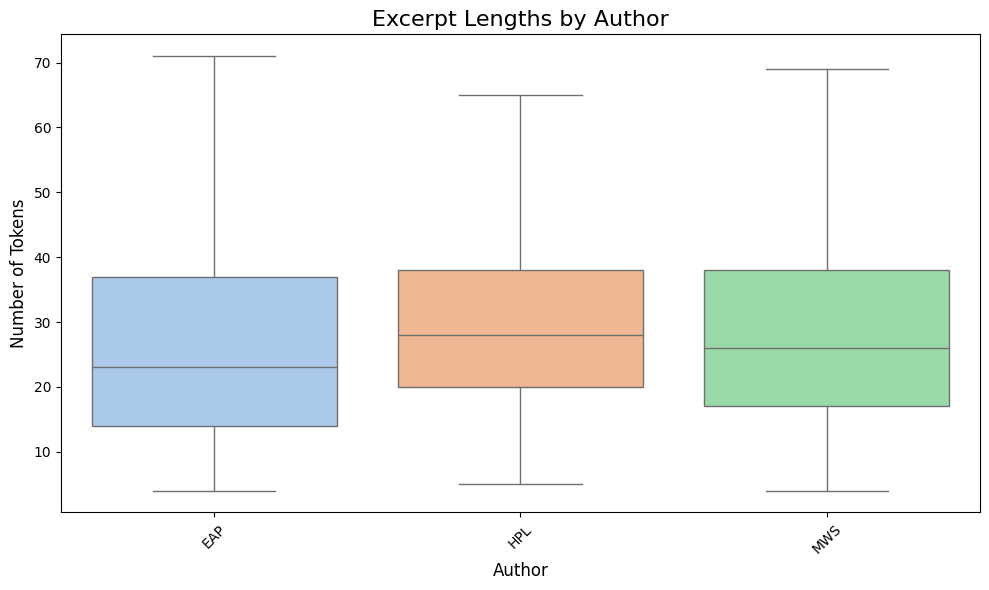

In [63]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='author', y='num_tokens', data=pdf, hue='author', palette='pastel', showfliers=False)
plt.title("Excerpt Lengths by Author", fontsize=16)
plt.xlabel("Author", fontsize=12)
plt.ylabel("Number of Tokens", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Figure_2b.png", dpi=300, bbox_inches='tight')
plt.show()


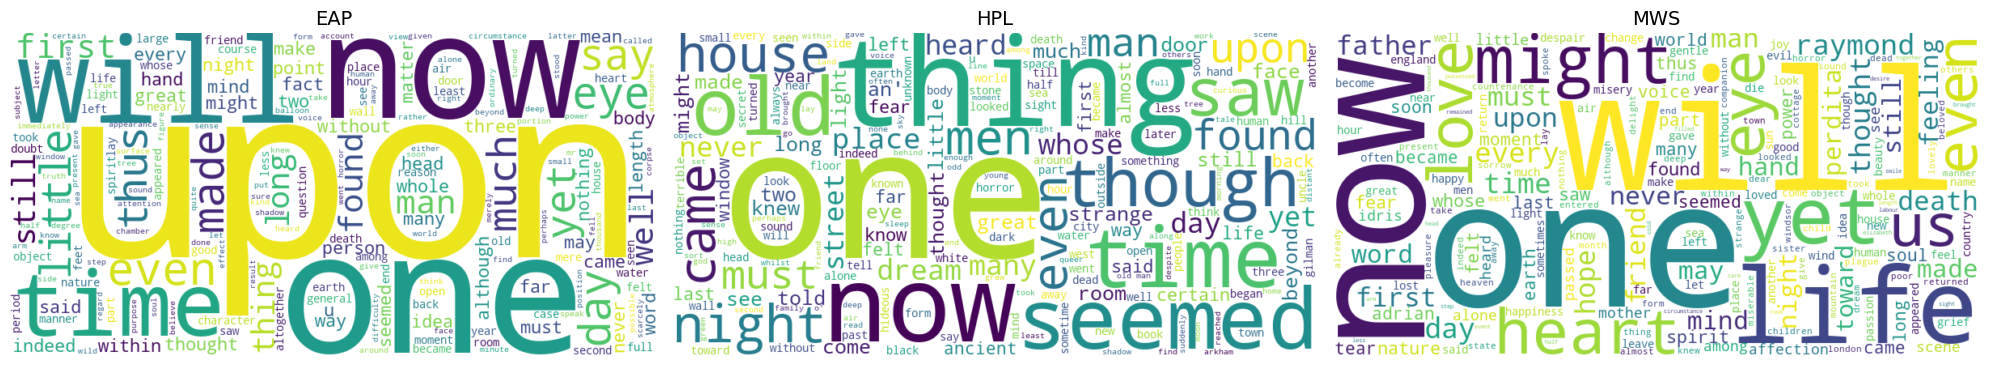

In [64]:
authors = pdf['author'].unique()
plt.figure(figsize=(20, 6))
for i, author in enumerate(authors, 1):
    text = " ".join(pdf[pdf['author'] == author]['text'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white',
                   colormap='viridis').generate(text)
    plt.subplot(1, len(authors), i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(author, fontsize=14)
plt.tight_layout()
plt.savefig("Figure_3.png", dpi=300, bbox_inches='tight')
plt.show()


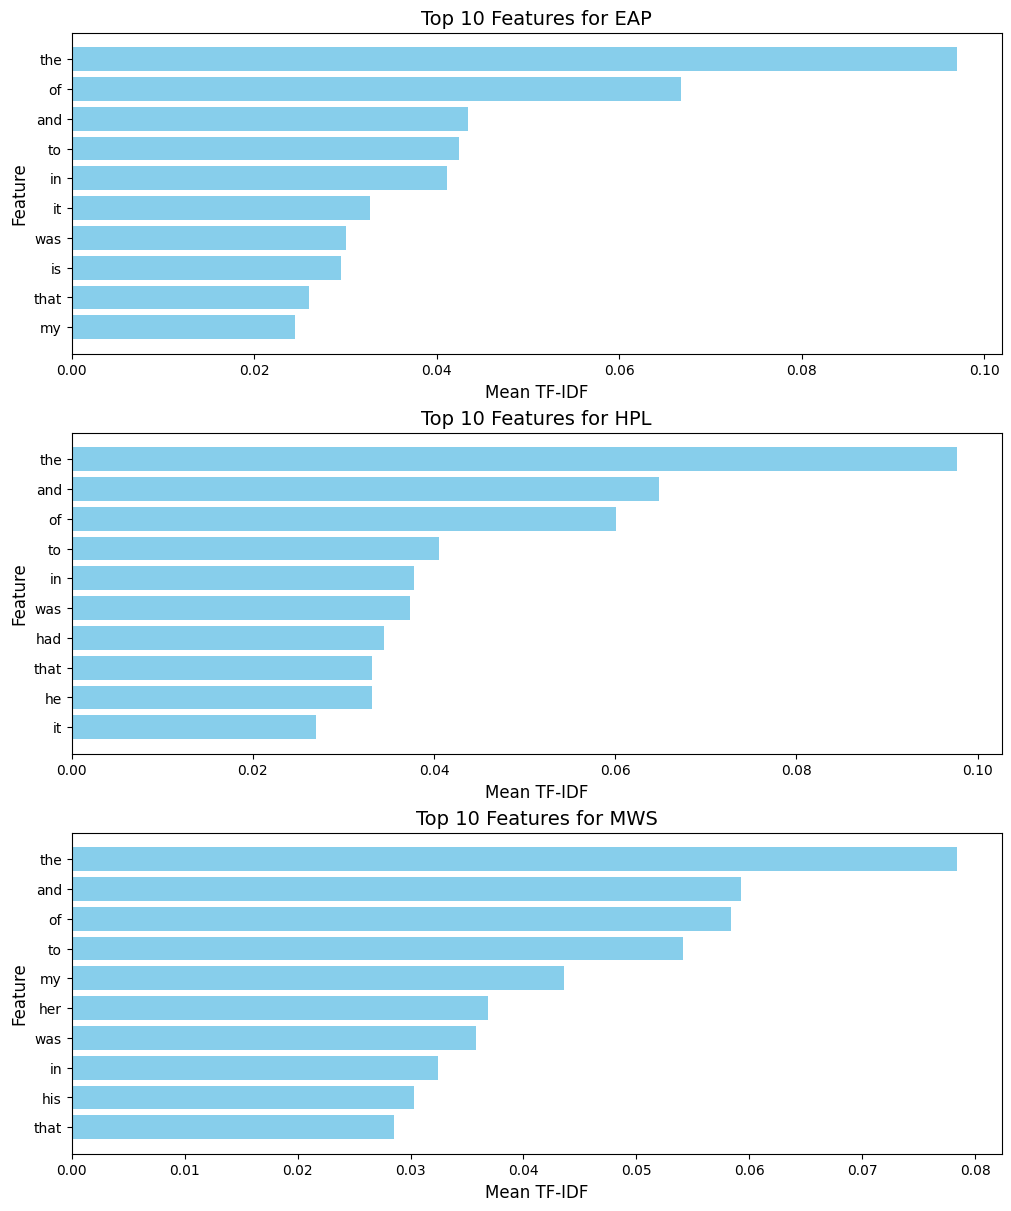

In [65]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(pdf['text'])
feature_names = vectorizer.get_feature_names_out()

authors = pdf['author'].unique()
fig, axes = plt.subplots(len(authors), 1, figsize=(10, 4 * len(authors)), constrained_layout=True)

for i, author in enumerate(authors):
    mask = (pdf['author'] == author).values
    row_indices = np.where(mask)[0]
    mean_tfipdf = X[row_indices].mean(axis=0)
    mean_tfipdf = np.asarray(mean_tfipdf).ravel()

    top_idx = mean_tfipdf.argsort()[-10:][::-1]

    axes[i].barh([feature_names[j] for j in top_idx][::-1],
                 mean_tfipdf[top_idx][::-1],
                 color='skyblue')
    axes[i].set_title(f"Top 10 Features for {author}", fontsize=14)
    axes[i].set_xlabel("Mean TF-IDF", fontsize=12)
    axes[i].set_ylabel("Feature", fontsize=12)

plt.savefig("Figure_4.png", dpi=300, bbox_inches='tight')
plt.show()

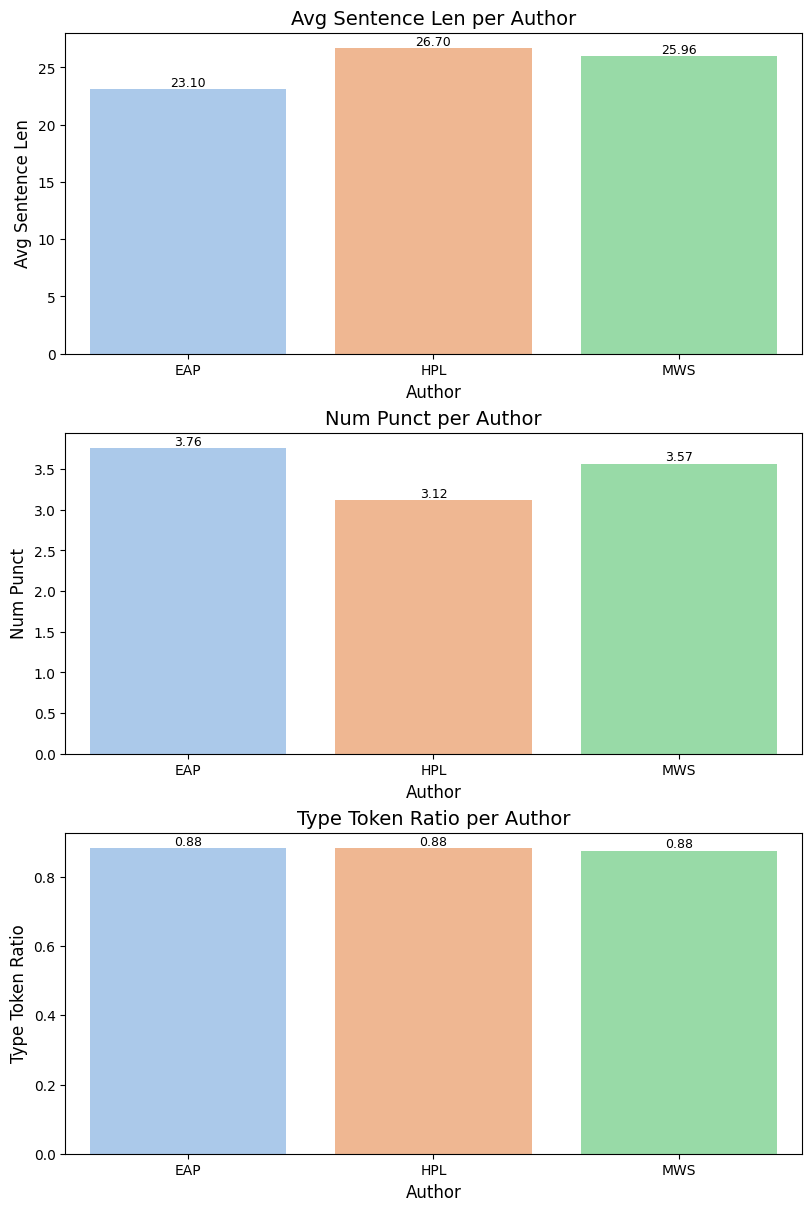

In [66]:
stylistic_features = pd.DataFrame()
stylistic_features['author'] = pdf['author']

# Average sentence length
stylistic_features['avg_sentence_len'] = pdf['text'].apply(
    lambda x: np.mean([len(sent.split()) for sent in str(x).split('.') if sent])
)

# Number of punctuation marks
stylistic_features['num_punct'] = pdf['text'].apply(
    lambda x: sum(1 for c in str(x) if c in string.punctuation)
)

# Type-token ratio
def type_token_ratio(text):
    tokens = [w for w in str(text).split() if w.isalpha()]
    return len(set(tokens)) / (len(tokens) + 1e-9)

stylistic_features['type_token_ratio'] = pdf['text'].apply(type_token_ratio)

features = ['avg_sentence_len', 'num_punct', 'type_token_ratio']
fig, axes = plt.subplots(len(features), 1, figsize=(8, 4 * len(features)), constrained_layout=True)

for i, feat in enumerate(features):
    sns.barplot(x='author', y=feat, data=stylistic_features, hue='author', palette='pastel', ax=axes[i], errorbar=None)
    axes[i].set_title(f"{feat.replace('_',' ').title()} per Author", fontsize=14)
    axes[i].set_xlabel("Author", fontsize=12)
    axes[i].set_ylabel(feat.replace('_',' ').title(), fontsize=12)
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(f"{height:.2f}", (p.get_x() + p.get_width()/2, height),
                         ha='center', va='bottom', fontsize=9)

plt.savefig("Figure_5.png", dpi=300, bbox_inches='tight')
plt.show()


## 5. Preprocess for modeling
We:
- Limit to top N authors (for manageable classification).
- Encode author labels.
- Tokenize text and pad sequences.
- Split into train, validation, and test sets.


In [67]:
N_AUTHORS = 10
selected_authors = pdf['author'].value_counts().nlargest(N_AUTHORS).index.tolist()
pdf = pdf[pdf['author'].isin(selected_authors)]

le = LabelEncoder()
pdf['label'] = le.fit_transform(pdf['author'])

X = pdf['text'].tolist()
y = pdf['label'].values

# Tokenize & pad
MAX_VOCAB = 20000
MAX_LEN = 200
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(padded, y, test_size=0.3, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)


## 6. Define & train baseline LSTM model
The model architecture:
- Embedding layer  
- Bidirectional LSTM  
- Dropout  
- Dense softmax output layer  

We also apply class weights to address class imbalance.


In [68]:
num_classes = len(le.classes_)

def make_lstm(embed_dim=100, lstm_units=128, dropout=0.3):
    inputs = layers.Input(shape=(MAX_LEN,))
    x = layers.Embedding(MAX_VOCAB, embed_dim)(inputs)
    x = layers.SpatialDropout1D(dropout)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model = make_lstm()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizers.Adam(1e-3),
              metrics=["accuracy"])
model.summary()

# Class weights
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw = {i:w for i,w in enumerate(cw)}

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=64,
                    class_weight=cw,
                    callbacks=[es])


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 200, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,235,267 (8.53 MB)

 Trainable params: 2,235,267 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 194s 963ms/step - accuracy: 0.5629 - loss: 0.9056 - val_accuracy: 0.7200 - val_loss: 0.6714
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 182s 920ms/step - accuracy: 0.8363 - loss: 0.4217 - val_accuracy: 0.7965 - val_loss: 0.5113
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 182s 920ms/step - accuracy: 0.9192 - loss: 0.2232 - val_accuracy: 0.8072 - val_loss: 0.5566
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 182s 918ms/step - accuracy: 0.9462 - loss: 0.1549 - val_accuracy: 0.8031 - val_loss: 0.5733
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 178s 898ms/step - accuracy: 0.9645 - loss: 0.1047 - val_accuracy: 0.7422 - val_loss: 0.8333


## 7. Evaluate baseline model
We check accuracy, generate a classification report, and plot a confusion matrix.


Test Accuracy: 0.7984
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step
              precision    recall  f1-score   support

         EAP       0.87      0.71      0.78      1057
         HPL       0.77      0.86      0.81       818
         MWS       0.77      0.86      0.81       833

    accuracy                           0.80      2708
   macro avg       0.80      0.81      0.80      2708
weighted avg       0.81      0.80      0.80      2708



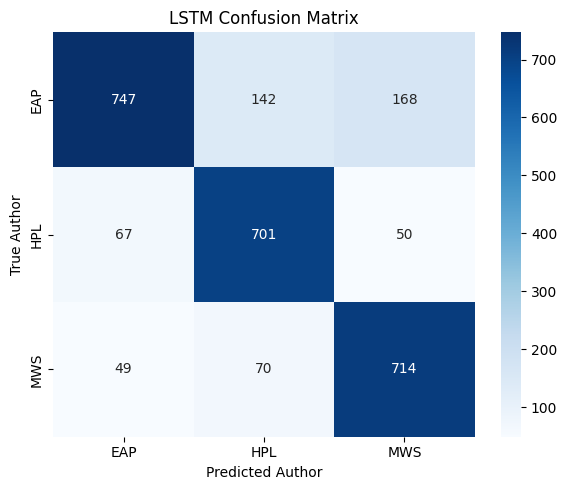

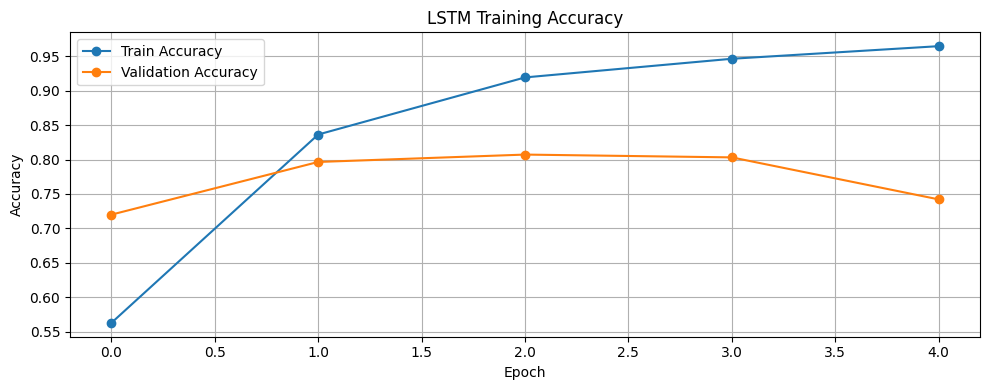

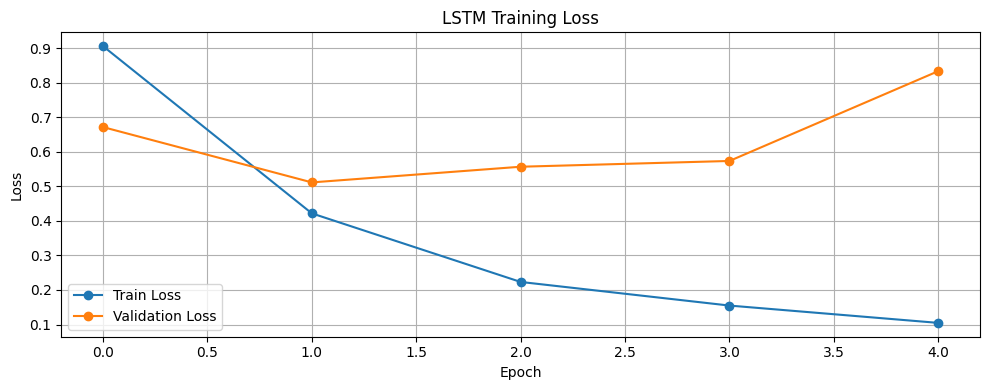

In [69]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.tight_layout()
plt.savefig("Figure_7.png", dpi=300, bbox_inches='tight')
plt.show()

# Training curves
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Figure_6a.png", dpi=300, bbox_inches='tight')
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Figure_6b.png", dpi=300, bbox_inches='tight')
plt.show()


## 8. Retrain with improved hyperparameters
We try a bigger embedding dimension and more LSTM units, and compare performance.


In [70]:
# -- Improved retrain LSTM
model2 = make_lstm(embed_dim=150,    # moderate embedding size
                   lstm_units=160,   # moderate LSTM units
                   dropout=0.3)      # standard dropout

# Use a slightly higher learning rate than your last retrain
model2.compile(loss="sparse_categorical_crossentropy",
               optimizer=optimizers.Adam(5e-4),
               metrics=["accuracy"])

# Early stopping to prevent overfitting
es2 = callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

# Train for more epochs to allow convergence
history2 = model2.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      epochs=20,       # increased from 10
                      batch_size=64,
                      class_weight=cw,
                      callbacks=[es2])

# Evaluate on test set
test_loss2, test_acc2 = model2.evaluate(X_test, y_test, verbose=0)
print(f"Improved Retrain Test Accuracy: {test_acc2:.4f}")


Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.5374 - loss: 0.9347 - val_accuracy: 0.6816 - val_loss: 0.7411
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7937 - loss: 0.5065 - val_accuracy: 0.7880 - val_loss: 0.5381
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.9008 - loss: 0.2686 - val_accuracy: 0.7883 - val_loss: 0.5434
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.9394 - loss: 0.1704 - val_accuracy: 0.7861 - val_loss: 0.6448
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9530 - loss: 0.1367 - val_accuracy: 0.8005 - val_loss: 0.6316
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9685 - loss: 0.0921 - val_accuracy: 0.7909 - val_loss: 0.7258
Improved Retrain Test Accuracy: 0.7917


### Comparison of Baseline vs Improved Retrain

Baseline Model Test Accuracy: 0.7984
Improved Retrain Model Test Accuracy: 0.7917
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step

--- Baseline Model Classification Report ---
              precision    recall  f1-score   support

         EAP       0.87      0.71      0.78      1057
         HPL       0.77      0.86      0.81       818
         MWS       0.77      0.86      0.81       833

    accuracy                           0.80      2708
   macro avg       0.80      0.81      0.80      2708
weighted avg       0.81      0.80      0.80      2708


--- Improved Retrain Model Classification Report ---
              precision    recall  f1-score   support

         EAP       0.85      0.70      0.77      1057
         HPL       0.78      0.87      0.82       818
         MWS       0.74      0.84      0.79       833

    accuracy                           0.79      2708
   macro avg       0.79      0.80      0.79      2708
weighted avg       0.80    

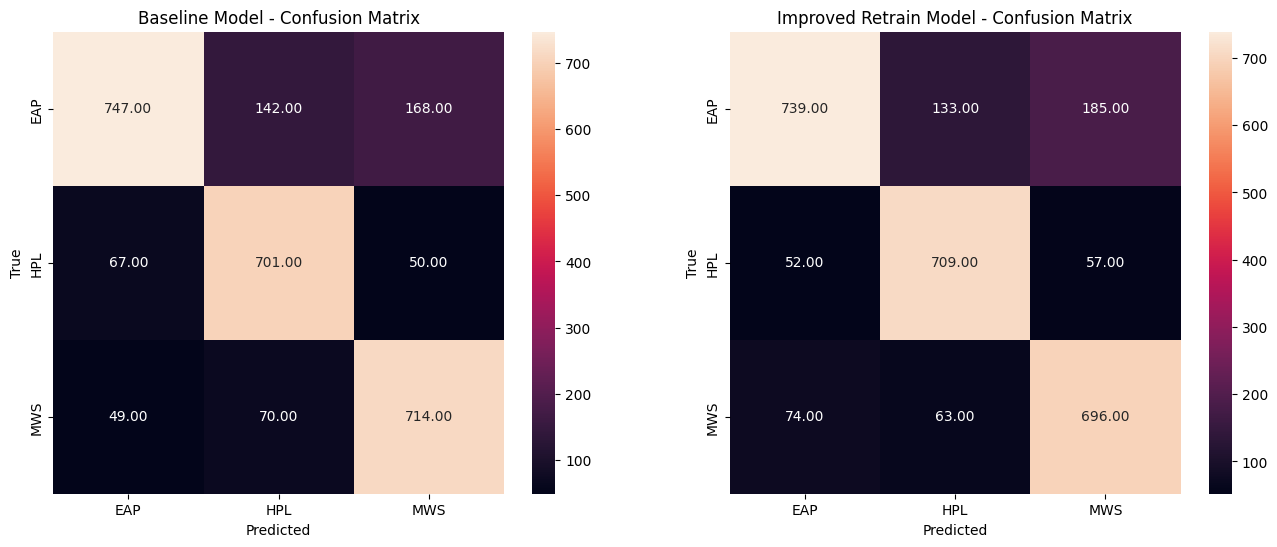

In [71]:
# Evaluate both models on test set
baseline_loss, baseline_acc = model.evaluate(X_test, y_test, verbose=0)
improved_loss, improved_acc = model2.evaluate(X_test, y_test, verbose=0)

print(f"Baseline Model Test Accuracy: {baseline_acc:.4f}")
print(f"Improved Retrain Model Test Accuracy: {improved_acc:.4f}")

# Get predictions for classification report
y_pred_baseline = np.argmax(model.predict(X_test), axis=1)
y_pred_improved = np.argmax(model2.predict(X_test), axis=1)

# Classification reports
print("\n--- Baseline Model Classification Report ---")
print(classification_report(y_test, y_pred_baseline, target_names=le.classes_))

print("\n--- Improved Retrain Model Classification Report ---")
print(classification_report(y_test, y_pred_improved, target_names=le.classes_))

# Normalized confusion matrices
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_improved = confusion_matrix(y_test, y_pred_improved)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.heatmap(cm_baseline, annot=True, fmt=".2f", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Baseline Model - Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")

plt.subplot(1,2,2)
sns.heatmap(cm_improved, annot=True, fmt=".2f", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Improved Retrain Model - Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")

plt.show()
